<a href="https://colab.research.google.com/github/juhiishah/Kaggle-House-Prices-Advanced-Regression-Techniques/blob/master/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning Data/Churn_Modelling.csv')

In [12]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
len(df)

10000

In [13]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [14]:
# Dropping unnecessary columns
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [15]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [16]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [17]:
# Separating Categorical and Continuous Values

cat_cols = ['Geography','Gender']
cont_cols = ['CreditScore','Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
y_col = ['Exited']

In [19]:
# Convert categorical columns to category dtype

for cat in cat_cols:
  df[cat]  = df[cat].astype('category')

In [20]:
df.dtypes

CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard             int64
IsActiveMember        int64
EstimatedSalary     float64
Exited                int64
dtype: object

In [22]:
# Shuffle the dataset

df = shuffle(df, random_state=101)
df.reset_index(drop=True,inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Spain,Male,52,8,0.00,2,1,1,123242.11,0
1,616,France,Male,23,8,73112.95,1,1,1,62733.05,0
2,516,France,Female,46,6,62212.29,1,0,1,171681.86,1
3,494,France,Male,28,9,114731.76,2,0,1,79479.74,0
4,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1


In [23]:
# Set embedding sizes

cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,size+1//2)) for size in cat_szs]
emb_szs

[(3, 3), (2, 2)]

In [24]:
# Create an array of categorical values

gphy = df['Geography'].cat.codes.values 
gnd = df['Gender'].cat.codes.values

In [25]:
cats = np.stack([gphy,gnd], 1)
cats[:5]

array([[2, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [1, 0]], dtype=int8)

In [26]:
# Convert cats to tensors
cats = torch.tensor(cats, dtype=torch.int64)

In [27]:
# Create an array of continuous values

conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[6.1900000e+02, 5.2000000e+01, 8.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.2324211e+05],
       [6.1600000e+02, 2.3000000e+01, 8.0000000e+00, 7.3112950e+04,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 6.2733050e+04],
       [5.1600000e+02, 4.6000000e+01, 6.0000000e+00, 6.2212290e+04,
        1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.7168186e+05],
       [4.9400000e+02, 2.8000000e+01, 9.0000000e+00, 1.1473176e+05,
        2.0000000e+00, 0.0000000e+00, 1.0000000e+00, 7.9479740e+04],
       [6.5500000e+02, 4.6000000e+01, 7.0000000e+00, 1.3714512e+05,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.1514640e+05]])

In [31]:
conts = torch.tensor(conts, dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [29]:
# Convert a label tensor
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 0, 1,  ..., 0, 0, 0])

In [32]:
# Create train test split from cats conts y

batch_size = 10000
test_size = 2000

cats_train = cats[:batch_size-test_size]
cats_test = cats[batch_size-test_size:batch_size]
conts_train = conts[:batch_size-test_size]
conts_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [33]:
len(cats_train)

8000

In [34]:
len(cats_test)

2000

In [35]:
# Define the Model Class

In [36]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [37]:
# Create Tabular Model instances

In [38]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],2,[50],p=0.4)

In [39]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [40]:
# Define Loss Function and optimization function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Train the Model

In [42]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
  i+=1
  y_pred = model(cats_train,conts_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss)

  if i%10==1:
    print(f'epochs: {i:3} loss: {loss.item():10.8f}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(f'\n Duration {time.time() - start_time:.0f} seconds')

epochs:   1 loss: 0.74866682
epochs:  11 loss: 0.67456269
epochs:  21 loss: 0.62875772
epochs:  31 loss: 0.59632647
epochs:  41 loss: 0.57099974
epochs:  51 loss: 0.55645555
epochs:  61 loss: 0.53755367
epochs:  71 loss: 0.52277273
epochs:  81 loss: 0.50627720
epochs:  91 loss: 0.48955226
epochs: 101 loss: 0.47046790
epochs: 111 loss: 0.45277530
epochs: 121 loss: 0.44111195
epochs: 131 loss: 0.42934594
epochs: 141 loss: 0.41930312
epochs: 151 loss: 0.40468898
epochs: 161 loss: 0.39493066
epochs: 171 loss: 0.39434183
epochs: 181 loss: 0.37750635
epochs: 191 loss: 0.38287055
epochs: 201 loss: 0.37544191
epochs: 211 loss: 0.37811995
epochs: 221 loss: 0.37279031
epochs: 231 loss: 0.36743203
epochs: 241 loss: 0.36671147
epochs: 251 loss: 0.36208102
epochs: 261 loss: 0.36285466
epochs: 271 loss: 0.36212710
epochs: 281 loss: 0.36167949
epochs: 291 loss: 0.35648501

 Duration 14 seconds


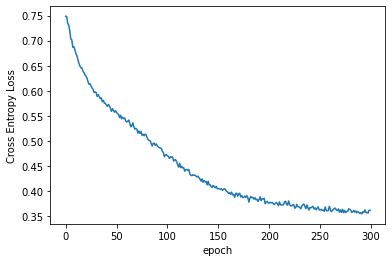

In [43]:
# Plot the Cross Entropy Loss against epochs
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [44]:
# Evaluate the test size

with torch.no_grad():
  y_val = model(cats_test,conts_test)
  loss = criterion(y_val, y_test)

print(f'Cross Entropy Loss: {loss:.8f}')

Cross Entropy Loss: 0.37043929


In [45]:
# Calculate the overall percent accuracy

correct = 0

for i in range(len(y_test)):
  if y_val[i].argmax().item() == y_test[i]:
    correct += 1

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')


1698 out of 2000 = 84.90% correct
